In [180]:
import networkx as nx
import networkx.algorithms.approximation as nx_app
import random
import matplotlib.pyplot as plt
from scipy.optimize import milp
from scipy.optimize import LinearConstraint
import numpy as np
import math
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

{(0, 1): Text(0.4807288752780542, -0.6385655895199198, '8'),
 (0, 9): Text(-0.19947652302192204, -0.6943764464070816, '0'),
 (0, 5): Text(0.21762838266185602, -0.672406215826934, '0'),
 (1, 2): Text(0.8172829235683253, -0.12707727190419454, '2'),
 (1, 3): Text(0.5449340829234102, 0.11606825048345432, '10'),
 (2, 5): Text(0.5541824309521272, -0.16091789821120883, '7'),
 (2, 8): Text(0.4265524339550016, 0.15328973455328354, '5'),
 (4, 9): Text(-0.7823762473108182, -0.09444217751662967, '1'),
 (4, 6): Text(-0.6872216233394645, 0.21365850264883707, '3'),
 (4, 7): Text(-0.7195170288899836, 0.5473438827358279, '6'),
 (9, 8): Text(-0.27527758593498386, -0.11621846876645807, '1'),
 (3, 7): Text(-0.07241209695573148, 0.7020434538487499, '0'),
 (3, 6): Text(-0.040116691405212374, 0.36835807376175916, '7'),
 (7, 8): Text(-0.21241836751414928, 0.5255675914859994, '1'),
 (6, 5): Text(-0.052492964966504546, -0.12232542136548369, '1')}

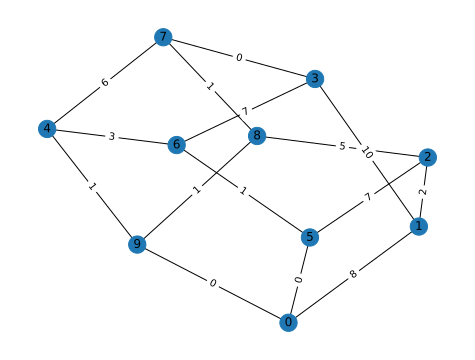

In [181]:
G = nx.random_regular_graph(3, 10)
pos = nx.spring_layout(G)
for (u, v) in G.edges():
    G.edges[u, v]['weight'] = random.randint(0, 10)
nx.draw(G, pos, with_labels=True)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

In [182]:
# find a set of edges such that each node has one outgoing edge, one incoming edge, minimize the number of edges
c = np.ones(len(G.edges))
for i, (u, v) in enumerate(G.edges()):
    c[i] = G.edges[u, v]['weight']
b_u = 2*np.ones(len(G.nodes)) # we need exactly 2 edges for each node (non-directed graph)
b_l = 2*np.ones(len(G.nodes))
A = np.zeros((len(G.nodes), len(G.edges)))

for j, v in enumerate(G.nodes): # one line in A per node
    for i, e in enumerate(G.edges): # one column in A per edge
        if e[0] == v or e[1] == v:
            A[j, i] = 1

constraints = LinearConstraint(A, b_l, b_u)
res = milp(c=c, constraints=constraints, integrality=np.ones(len(G.edges)), bounds=(0, 1)) # integer LP solver

In [183]:
edge_list = [] # get list of edges from solver solution
for i, e in enumerate(G.edges):
    if res["x"][i] == 1:
        edge_list.append(e)

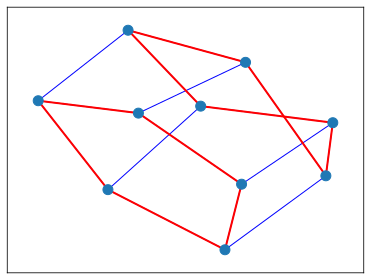

In [184]:
# draw network and edge list
nx.draw_networkx_nodes(G, pos, node_size=100)
nx.draw_networkx_edges(G, pos, edgelist=G.edges, width=1, edge_color="b")
nx.draw_networkx_edges(G, pos, edgelist=edge_list, width=2, edge_color="r")

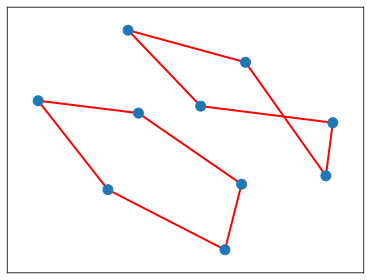

In [185]:
H = nx.Graph()
H.add_edges_from(edge_list)
nx.draw_networkx_nodes(H, pos, node_size=100)
nx.draw_networkx_edges(H, pos, edgelist=H.edges, width=2, edge_color="r")

In [186]:
while len(list(nx.connected_components(H))) > 1:
    n = A.shape[0]

    for i, cc in enumerate(nx.connected_components(H)):
        row = np.zeros(len(G.edges))
        A = np.vstack([A, row])
        b_l = np.hstack([b_l, 1])
        b_u = np.hstack([b_u, np.inf]) 
        for j, e in enumerate(G.edges()):
            for v in cc:
                if (e[0] == v and e[1] not in cc) or (e[1] == v and e[0] not in cc):
                        A[n + i, j] = 1
    
    constraints = LinearConstraint(A, b_l, b_u)
    res = milp(c=c, constraints=constraints, integrality=np.ones(len(G.edges)), bounds=(0, 1))

    edge_list = []
    for i, e in enumerate(G.edges):
        if res["x"][i] == 1:
            edge_list.append(e)

    H = nx.Graph()
    H.add_edges_from(edge_list)

{(0, 1): Text(0.4807288752780542, -0.6385655895199198, '8'),
 (0, 9): Text(-0.19947652302192204, -0.6943764464070816, '0'),
 (0, 5): Text(0.21762838266185602, -0.672406215826934, '0'),
 (1, 2): Text(0.8172829235683253, -0.12707727190419454, '2'),
 (1, 3): Text(0.5449340829234102, 0.11606825048345432, '10'),
 (2, 5): Text(0.5541824309521272, -0.16091789821120883, '7'),
 (2, 8): Text(0.4265524339550016, 0.15328973455328354, '5'),
 (4, 9): Text(-0.7823762473108182, -0.09444217751662967, '1'),
 (4, 6): Text(-0.6872216233394645, 0.21365850264883707, '3'),
 (4, 7): Text(-0.7195170288899836, 0.5473438827358279, '6'),
 (9, 8): Text(-0.27527758593498386, -0.11621846876645807, '1'),
 (3, 7): Text(-0.07241209695573148, 0.7020434538487499, '0'),
 (3, 6): Text(-0.040116691405212374, 0.36835807376175916, '7'),
 (7, 8): Text(-0.21241836751414928, 0.5255675914859994, '1'),
 (6, 5): Text(-0.052492964966504546, -0.12232542136548369, '1')}

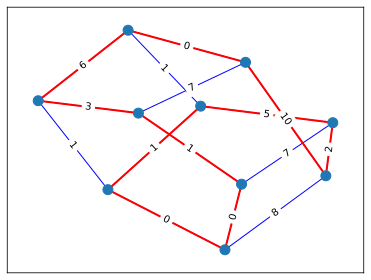

In [187]:
nx.draw_networkx_nodes(G, pos, node_size=100)
nx.draw_networkx_edges(G, pos, edgelist=G.edges, width=1, edge_color="b")
nx.draw_networkx_edges(G, pos, edgelist=edge_list, width=2, edge_color="r")
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)